In [72]:
import pandas as pd
import numpy as np
import torch

In [73]:
TRAINING_PATH = 'BenchmarkDatasets/NoAuction/3.NoAuction_DecPre/NoAuction_DecPre_Training'
TESTING_PATH = 'BenchmarkDatasets/NoAuction/3.NoAuction_DecPre/NoAuction_DecPre_Testing'

dec_data = np.loadtxt(f'{TRAINING_PATH}/Train_Dst_NoAuction_DecPre_CF_7.txt')


dec_train = dec_data[:, :int(np.floor(dec_data.shape[1] * 0.8))]
dec_val = dec_data[:, int(np.floor(dec_data.shape[1] * 0.8)):]

dec_test1 = np.loadtxt(f'{TESTING_PATH}/Test_Dst_NoAuction_DecPre_CF_7.txt')
dec_test2 = np.loadtxt(f'{TESTING_PATH}/Test_Dst_NoAuction_DecPre_CF_8.txt')
dec_test3 = np.loadtxt(f'{TESTING_PATH}/Test_Dst_NoAuction_DecPre_CF_9.txt')
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))

print(dec_train.shape, dec_val.shape, dec_test.shape)

(149, 203800) (149, 50950) (149, 139587)


In [75]:
def prepare_x(data):
    df = pd.DataFrame(data)
    df40 = df.iloc[:40, :].T
    new_column_names = []
    for i in range(1, 11):
        new_column_names.append(f"ask_price_level_{i}")
        new_column_names.append(f"ask_volume_level_{i}")
        new_column_names.append(f"bid_price_level_{i}")
        new_column_names.append(f"bid_volume_level_{i}")
    
    df40.columns = new_column_names
    return df40

def get_label(data):
    df = pd.DataFrame(data)
    lob = df.iloc[-5:, :].T
    horizon = [1, 2, 3, 5, 10]
    new_column_names = []
    for i in range(5):
        new_column_names.append(f"Horizon at {horizon[i]}")
    
    lob.columns = new_column_names
    return lob

In [76]:
df_x = prepare_x(dec_train)
df_y_train = get_label(dec_train)


,ask_price_level_1,ask_volume_level_1,bid_price_level_1,bid_volume_level_1,ask_price_level_2,ask_volume_level_2,bid_price_level_2,bid_volume_level_2,ask_price_level_3,ask_volume_level_3,...,ask_price_level_9,ask_volume_level_9,bid_price_level_9,bid_volume_level_9,ask_price_level_10,ask_volume_level_10,bid_price_level_10,bid_volume_level_10,MidPrice,LogReturn
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.2615,0.00353,0.2606,0.00326,0.2618,0.00200,0.2604,0.00682,0.2619,0.00164,...,0.2629,0.00146,0.2588,0.00123,0.2633,0.00311,0.2579,0.00128,0.26105,NaN
2,0.2615,0.00211,0.2606,0.00326,0.2619,0.00164,0.2604,0.00682,0.2620,0.00138,...,0.2637,0.00165,0.2591,0.00134,0.2646,0.00138,0.2588,0.00123,0.26105,0.000000
3,0.2614,0.00122,0.2606,0.00326,0.2615,0.00200,0.2604,0.00682,0.2617,0.00361,...,0.2629,0.00146,0.2591,0.00134,0.2633,0.00311,0.2588,0.00123,0.26100,-0.000192
4,0.2614,0.00322,0.2606,0.00326,0.2617,0.00938,0.2604,0.00682,0.2619,0.00850,...,0.2637,0.00165,0.2588,0.00123,0.2646,0.00138,0.2579,0.00128,0.26100,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203795,0.3639,0.00218,0.3634,0.00339,0.3643,0.00094,0.3631,0.00590,0.3644,0.01256,...,0.3655,0.00400,0.3622,0.00005,0.3657,0.00040,0.3621,0.00194,0.36365,0.000000
203796,0.3639,0.00218,0.3634,0.00339,0.3643,0.00094,0.3631,0.00590,0.3644,0.01256,...,0.3655,0.00400,0.3622,0.00005,0.3657,0.00040,0.3621,0.00194,0.36365,0.000000
203797,0.3639,0.00218,0.3634,0.00339,0.3643,0.00094,0.3631,0.00590,0.3644,0.01256,...,0.3653,0.00176,0.3622,0.00005,0.3655,0.00400,0.3621,0.00194,0.36365,0.000000
203798,0.3639,0.00218,0.3634,0.00339,0.3643,0.00094,0.3631,0.00590,0.3644,0.01256,...,0.3653,0.00176,0.3622,0.00005,0.3655,0.00400,0.3621,0.00194,0.36365,0.000000


In [92]:
def create_volatility_label(df_x, horizons) :
    """
    Compute rolling volatility labels for specified horizons based on log returns.

    This function calculates the mid-price, computes the log returns, 
    and derives rolling standard deviations (volatility) for each horizon 
    in the provided list. It cleans up the data by dropping rows with NaN values.

    Parameters:
    ----------
    df_x : pd.DataFrame
        Input DataFrame containing at least bid and ask price columns.
        Assumes bid prices are in column index 0 and ask prices in column index 2.
        
    horizons : list of int
        A list of integers representing the rolling window sizes (horizons) 
        for which to calculate realized volatility.

    Returns:
        pd.DataFrame
        A DataFrame with additional columns:
        - 'MidPrice': The calculated mid-price for each row.
        - 'LogReturn': The log return of the mid-price.
        - 'RV_{k}': Rolling standard deviation (realized volatility) 
          for each horizon `k` in the list of horizons.
    """
    df_x['MidPrice'] = (df_x.loc[:, 'ask_price_level_1'] + df_x.loc[:, 'bid_price_level_1'])/2
    df_x['LogReturn'] = np.log(df_x['MidPrice'] / df_x['MidPrice'].shift(1))

    df_x = df_x.iloc[1:].reset_index(drop=True)

    for k in horizons:
        df_x[f'RV_{k}'] = df_x['LogReturn'].rolling(window=k).std()
    df_x.dropna(inplace=True)
    return df_x

horizons =  [10, 20, 30, 50, 100] 
df_volatility = create_volatility_label(df_x, horizons)

In [93]:
df_volatility

,ask_price_level_1,ask_volume_level_1,bid_price_level_1,bid_volume_level_1,ask_price_level_2,ask_volume_level_2,bid_price_level_2,bid_volume_level_2,ask_price_level_3,ask_volume_level_3,...,ask_volume_level_10,bid_price_level_10,bid_volume_level_10,MidPrice,LogReturn,RV_10,RV_20,RV_30,RV_50,RV_100
99,0.2627,0.00082,0.2617,0.00194,0.2629,0.00935,0.2616,0.00354,0.2630,0.00471,...,0.00200,0.2602,0.00395,0.26220,0.000000,0.000299,0.000339,0.000313,0.000298,0.000305
100,0.2627,0.00082,0.2617,0.00194,0.2629,0.00435,0.2616,0.00354,0.2630,0.00471,...,0.00200,0.2602,0.00395,0.26220,0.000000,0.000299,0.000335,0.000313,0.000297,0.000305
101,0.2627,0.00082,0.2617,0.00573,0.2628,0.00435,0.2616,0.00354,0.2630,0.00471,...,0.00200,0.2602,0.00395,0.26220,0.000000,0.000299,0.000335,0.000305,0.000284,0.000304
102,0.2626,0.00243,0.2617,0.00194,0.2627,0.00082,0.2615,0.00368,0.2629,0.00423,...,0.00138,0.2596,0.00138,0.26215,-0.000191,0.000273,0.000250,0.000306,0.000282,0.000305
103,0.2625,0.00267,0.2617,0.00194,0.2626,0.00243,0.2615,0.00368,0.2627,0.00082,...,0.00138,0.2596,0.00138,0.26210,-0.000191,0.000141,0.000254,0.000308,0.000277,0.000306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203794,0.3639,0.00218,0.3634,0.00339,0.3643,0.00094,0.3631,0.00590,0.3644,0.01256,...,0.00040,0.3621,0.00194,0.36365,0.000000,0.000000,0.000000,0.000251,0.000232,0.000178
203795,0.3639,0.00218,0.3634,0.00339,0.3643,0.00094,0.3631,0.00590,0.3644,0.01256,...,0.00400,0.3621,0.00194,0.36365,0.000000,0.000000,0.000000,0.000251,0.000232,0.000178
203796,0.3639,0.00218,0.3634,0.00339,0.3643,0.00094,0.3631,0.00590,0.3644,0.01256,...,0.00400,0.3621,0.00194,0.36365,0.000000,0.000000,0.000000,0.000251,0.000232,0.000178
203797,0.3639,0.00218,0.3634,0.00339,0.3643,0.00094,0.3631,0.00590,0.3644,0.01256,...,0.00400,0.3621,0.00194,0.36365,0.000000,0.000000,0.000000,0.000251,0.000232,0.000178


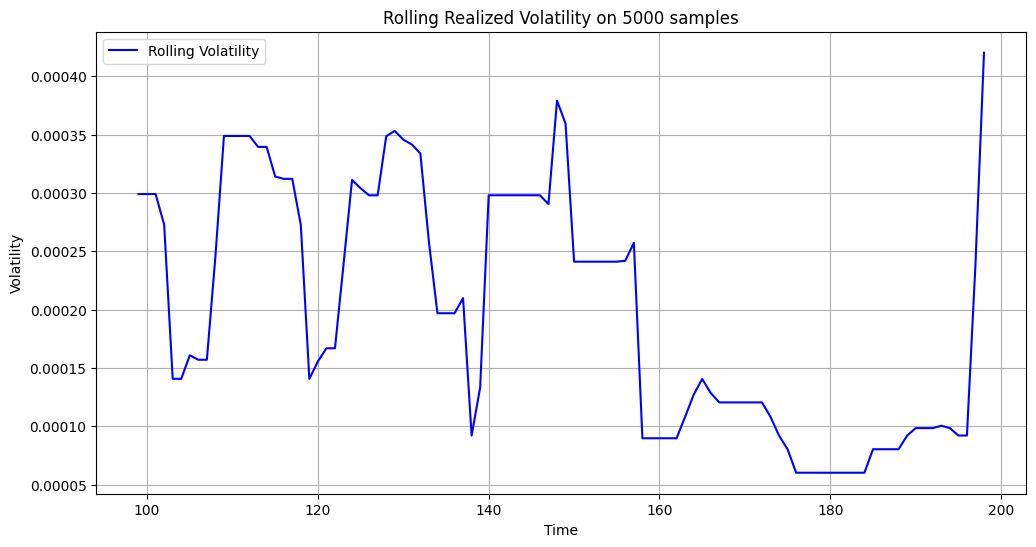

In [88]:
import matplotlib.pyplot as plt

sample_data = df_x_volatility['RV_10'].iloc[:100]
    for k in horizons :
    plt.figure(figsize=(12, 6))
    plt.plot(sample_data, label='Rolling Volatility', color='blue')
    plt.title('Rolling Realized Volatility on 5000 samples')
    plt.xlabel('Time')
    plt.ylabel('Volatility')
    plt.legend()
    plt.grid(True)
    plt.show()